This notebook analyzes the results from a run of the short c5g7 examples with a small mesh to determine the optimal parameters for the multilevel preconditioner when using RQI.

The parameters that were varied were the following:

* 'subspace_size' : [50, 100, 150],
* 'num_v_cycles'  : [1, 2, 3],
* 'num_relax'     : [1, 2, 3],
* 'relax_weight'  : [0.8, 1.0, 1.2]

In [18]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import glob
import sys
import os
import pandas as pd
import seaborn as sns

%matplotlib inline

In [19]:
solve_times = {}
for dir in glob.glob("../results/*"):
    d = os.path.basename(dir)
    output = '{}/c5g7_small.out.h5'.format(dir)
    with h5.File(str(output), 'r') as f:
        if 'denovo' in f.keys():
            solve_times[d] = f['denovo']['timers'][-1][1]
        else:
            print(d)

rayleigh_quotient-ss050-vcyc01-r01-rwt0.8
rayleigh_quotient-ss050-vcyc01-r01-rwt1.0
rayleigh_quotient-ss150-vcyc01-r01-rwt0.8


In [20]:
subspace = ['050', '100', '150']
vcyc = ['1', '2', '3']
relax = ['1', '2', '3']
relaxwt = ['0.8', '1.0', '1.2']
df = np.zeros((3,3,3,3))
for k,v in solve_times.iteritems():
    c = k.split('-')
    ss = c[1].strip('ss')
    vc = c[2].strip('vcyc0')
    rn = c[3].strip('r0')
    rwt = c[4].strip('rwt')
    ssi = subspace.index(ss)
    vci = vcyc.index(vc)
    rni = relax.index(rn)
    rwti = relaxwt.index(rwt)
    df[ssi, vci, rni, rwti] = v

In [21]:
# Set exceeds walltime to NaN
df[df==0] = np.nan
        
# Rearrange Timing Data to Match up with New Ordering
times = np.zeros(81)

i = 0
for counts in range(3):
    for cycles in range(3):
        for weight in range(3):
            for subspace in range(3):
                times[i] = df[subspace, cycles, counts, weight]
                i += 1
                
# Dividing by 1e4 so that annotations are easier to read
# Include explanation in figure caption
times = times/1e4

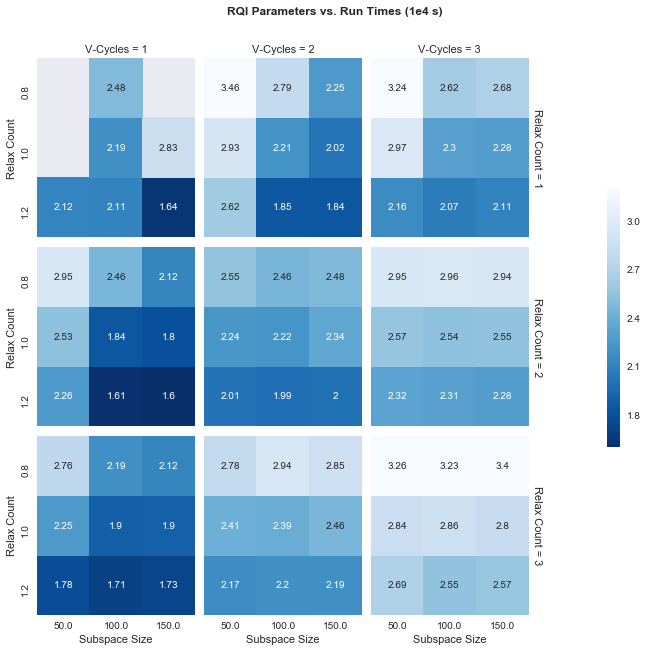

In [38]:
ss = np.tile([50, 100, 150], 27)
rw = np.tile(np.repeat([0.8, 1.0, 1.2], 3), 9)
vc = np.tile(np.repeat([1, 2, 3], 9), 3)
rc = np.repeat([1, 2, 3], 27)
parameters = np.c_[ss, rw, vc, rc, times]
data = pd.DataFrame(parameters, 
                  columns=["Subspace Size", "Relax Weight","V-Cycles", "Relax Count", "Times"])

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Relax Weight", columns="Subspace Size", values="Times") 
    sns.heatmap(data, cmap="Blues_r", annot=True,fmt='.3g', **kws)

grid = sns.FacetGrid(data, col="V-Cycles", row="Relax Count", margin_titles=True, 
                     col_order = [1, 2, 3], row_order=[1, 2, 3])

cbar_ax = grid.fig.add_axes([.92, .3, .02, .4])

grid = grid.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax, vmin=1.6, vmax=3.2) 
grid.set_axis_labels("Subspace Size", "Relax Weight")

plt.subplots_adjust(top=0.9)
grid.fig.suptitle('RQI Parameters vs. Run Times (1e4 s)', fontweight="bold")

grid = grid.fig.subplots_adjust(right=.8)

sns.plt.show()

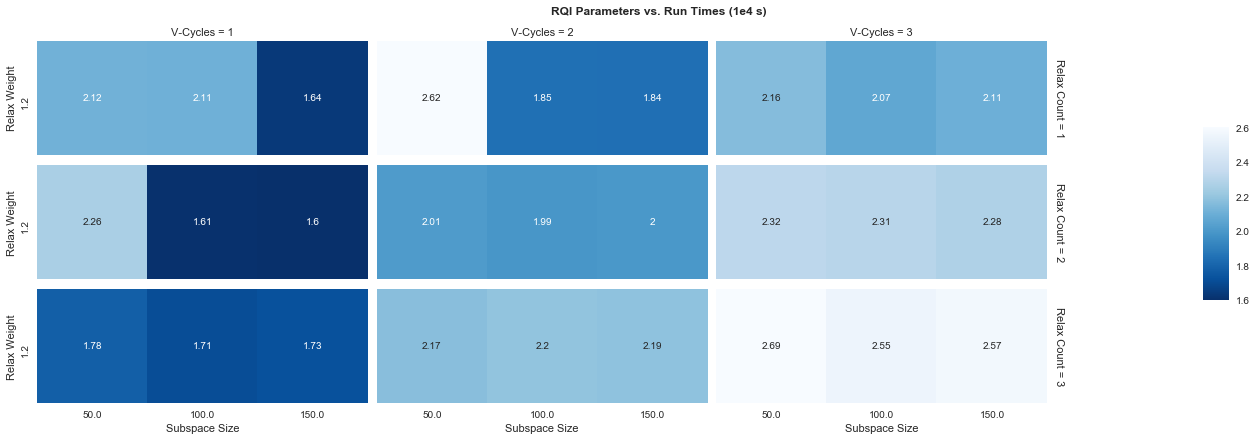

In [35]:
### Plot Fixing Relax Weight to 1.2 ###

# Find times with relax weight 1.2
fixed_rwt_times = np.zeros(27)
i = 0
for counts in range(3):
    for cycles in range(3):
        for subspace in range(3):
            fixed_rwt_times[i] = df[subspace, cycles, counts, 2]
            i += 1
# Divide by 1e4 for clarity of graph
fixed_rwt_times = fixed_rwt_times/1e4

ss = np.tile([50, 100, 150], 9)
rw = np.repeat(1.2, 27)
vc = np.tile(np.repeat([1, 2, 3], 3), 3)
rc = np.repeat([1, 2, 3], 9)              
parameters = np.c_[ss, rw, vc, rc, fixed_rwt_times]
data = pd.DataFrame(parameters, 
                  columns=["Subspace Size", "Relax Weight","V-Cycles", "Relax Count", "Times"])

def facet_heatmap(data, color, **kws):
    data = data.pivot(index="Relax Weight", columns="Subspace Size", values="Times") 
    sns.heatmap(data, cmap="Blues_r", annot=True, fmt='.3g', **kws)

grid = sns.FacetGrid(data, col="V-Cycles", row="Relax Count", margin_titles=True, 
                     col_order = [1, 2, 3], row_order=[1, 2, 3], size=2.0, aspect=3.0)

cbar_ax = grid.fig.add_axes([.92, .3, .02, .4])

grid = grid.map_dataframe(facet_heatmap,
                    cbar_ax=cbar_ax, vmin=1.6, vmax=2.6) 
grid.set_axis_labels("Subspace Size", "Relax Weight")

plt.subplots_adjust(top=0.9)
grid.fig.suptitle('RQI Parameters vs. Run Times with Fixed Relax Weight (1e4 s)', fontweight="bold")

grid = grid.fig.subplots_adjust(right=.8)

sns.plt.show()